## Importing the libraries and data

In [1]:
import pandas as pd
import string
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm
from PIL import Image
import cv2
%matplotlib inline

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,MobileNetV2


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model


## We import data and encode them

In [13]:
def preprocess_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

In [ ]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/image_paths_Outfits_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
df_image_paths = pd.DataFrame(data1)

In [ ]:
# Define a function to change the paths
def change_path(old_path):
    filename = old_path.split('/')[-1]  # Extract the filename
    new_path = '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/all_images/' + filename
    return new_path
# apply it to the dataframe
for column in df_image_paths.columns[:-1]:
    print(column)
    # Select all columns except the last one
    df_image_paths[column] = df_image_paths[column].apply(change_path)

In [14]:
y = df_image_paths["log_likes"].values

In [30]:
y.shape

(1973,)

In [16]:
#We keep the categories here
categories = df_image_paths.columns[0:6]

In [17]:
# getting the numpy values of the categories
df_image_paths_numpy = df_image_paths.iloc[:, 0:6].values


In [18]:
# Creates a vectorized version of our function 'preprocess_image_1' in order to apply it on each element of numpy array
vfunc = np.vectorize(preprocess_image_1, otypes=[np.ndarray])
df_images_numpy = vfunc(df_image_paths_numpy)

In [19]:
df_images_numpy[0][0].shape

(64, 64, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

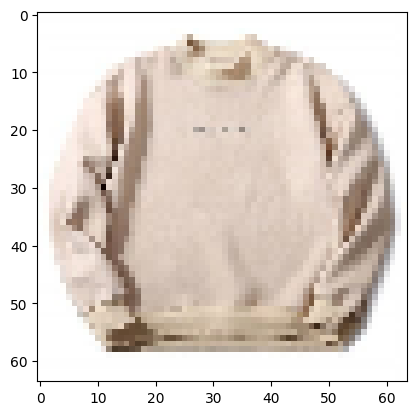

In [20]:
#printing some items for our help
plt.imshow(df_images_numpy[0][0])
plt.show

In [21]:
categories


Index(['Tops', 'Bottoms', 'Bags', 'Outwear', 'Shoes', 'Accessories'], dtype='object')

In [22]:
Tops_array = df_images_numpy[:,0]
Bottoms_array = df_images_numpy[:,1]
Bags_array = df_images_numpy[:,2]
Outwear_array = df_images_numpy[:,3]
Shoes_array = df_images_numpy[:,4]
Accessories_array = df_images_numpy[:,5]


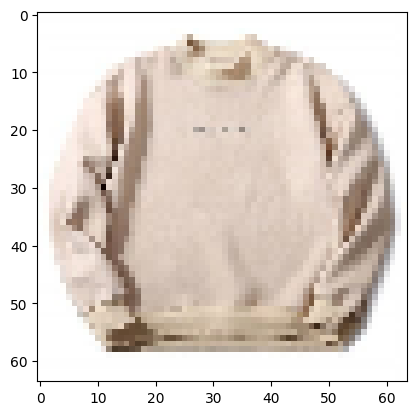

In [23]:
plt.imshow(Tops_array[0])



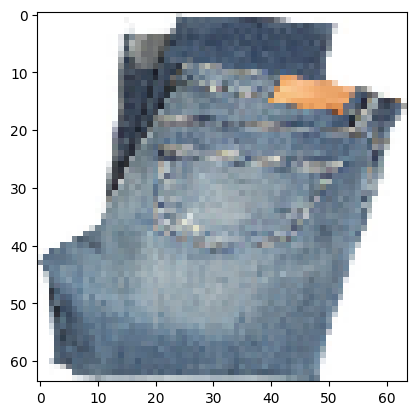

In [24]:
plt.imshow(Bottoms_array[0])


## Load encoder models and get the embeddings

In [25]:
# Loading all the encoders models and load them to a dictionary of models with name the categoty of the encoder that it corresponds
categories = df_image_paths.columns[0:6]
# Initialize a dictionary to hold your models
models = {}
model_path = '/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/'

# Loop through each category
for category in categories:
    # Construct the file path
    model_path = f"/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/{category}_embedding_model.h5"
    if os.path.exists(model_path):
            # Load the model and store it in the dictionary
            models[category] = load_model(model_path)
            print(f"{category} model loaded successfully.")
    else:
            print(f"No model available for {category}, file does not exist.")


Tops model loaded successfully.
Bottoms model loaded successfully.
Bags model loaded successfully.
Outwear model loaded successfully.
Shoes model loaded successfully.
Accessories model loaded successfully.


In [ ]:
####### IMPORTANT ##########
# Our arrays of the cloths have shape Tops_array.shape -->  (1973,) and the Tops_array[0] --> (64,64,3)
# Our input expects (batch_size, width, height, channels) or (1973,64,64,3) 
# To transform our dimensions and make it a 4D tensor we use np.stack

In [26]:
####### IMPORTANT ##########
# Our arrays of the cloths have shape Tops_array.shape -->  (1973,) and the Tops_array[0] --> (64,64,3)
# Our input expects (batch_size, width, height, channels) or (1973,64,64,3) 
# To transform our dimensions and make it a 4D tensor we use np.stack
Tops_array_4D = np.stack(Tops_array, axis=0)
Bottoms_array_4D = np.stack(Bottoms_array, axis=0)
Bags_array_4D = np.stack(Bags_array, axis=0)
Outwear_array_4D = np.stack(Outwear_array, axis=0)
Shoes_array_4D = np.stack(Shoes_array, axis=0)
Accessories_array_4D = np.stack(Accessories_array, axis=0)

In [27]:
Tops_array_4D.shape

(1973, 64, 64, 3)

In [28]:
Tops_embeddings = models['Tops'].predict(Tops_array_4D)
Bottoms_embeddings = models['Bottoms'].predict(Bottoms_array_4D)
Bags_embeddings = models['Bags'].predict(Bags_array_4D)
Outwear_embeddings = models['Outwear'].predict(Outwear_array_4D)
Shoes_embeddings = models['Shoes'].predict(Shoes_array_4D)
Accessories_embeddings = models['Accessories'].predict(Accessories_array_4D)

62/62 [==============================] - 2s 31ms/step


In [33]:
Tops_embeddings.shape

(1973, 16)

## We try to implement the model that takes as input images from different channels

In [ ]:
scaler = StandardScaler()

In [ ]:
y_scaled = scaler.fit_transform(y)

In [64]:
# Define the shape of your input images (height, width, channels)
input_shape = (16,)

In [51]:
# We map here every layer to a specific input
input_shape = (64,64,3)
# Create seven input layers
input1 = Input(shape=input_shape, name="Embeddings_Tops")
input2 = Input(shape=input_shape, name="Embeddings_Bottom")
input3 = Input(shape=input_shape, name="Embeddings_Shoes")
input4 = Input(shape=input_shape, name="Embeddings_Bags")
input5 = Input(shape=input_shape, name="Embeddings_Accessories")
#input6 = Input(shape=input_shape, name="Embeddings_Onepiece")
input6 = Input(shape=input_shape, name="Embeddings_Oterwear")

fc1 = Dense(128, activation='relu')(input1)
fc2 = Dense(128, activation='relu')(input2)
fc3 = Dense(128, activation='relu')(input3)
fc4 = Dense(128, activation='relu')(input4)
fc5 = Dense(128, activation='relu')(input5)
fc6 = Dense(128, activation='relu')(input6)
#fc7 = Dense(128, activation='relu')(input7)

# Concatenate all the fully connected layers' outputs
concatenated = Concatenate()([fc1, fc2, fc3, fc4, fc5, fc6])


# Additional Fully Connected layer on concatenated outputs
fc_final1 = Dense(128, activation='linear')(concatenated)
fc_final2 = Dense(64, activation='relu')(fc_final1)
fc_final3 = Dense(32, activation='relu')(fc_final2)
fc_final4 = Dense(4, activation='relu')(fc_final3)
output = Dense(1,activation='linear')(fc_final4)

# We create the model with the inputs
model = Model(inputs=[input1,input2, input3, input4, input5, input6], outputs=output)

# Compile the model 
model.compile(optimizer= tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error')

#keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)



In [49]:

history = model.fit(
    [Tops_embeddings,
     Bottoms_embeddings,
     Shoes_embeddings, 
     Bags_embeddings,
     Accessories_embeddings,
     Outwear_embeddings],
    y,
    epochs=100,
    batch_size=32,
    validation_split=0.1 # or use `validation_data=(X_val, y_val)` if you have separate validation data
)

Epoch 1/100


ValueError: in user code:

    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 1, 16), found shape=(None, 16)


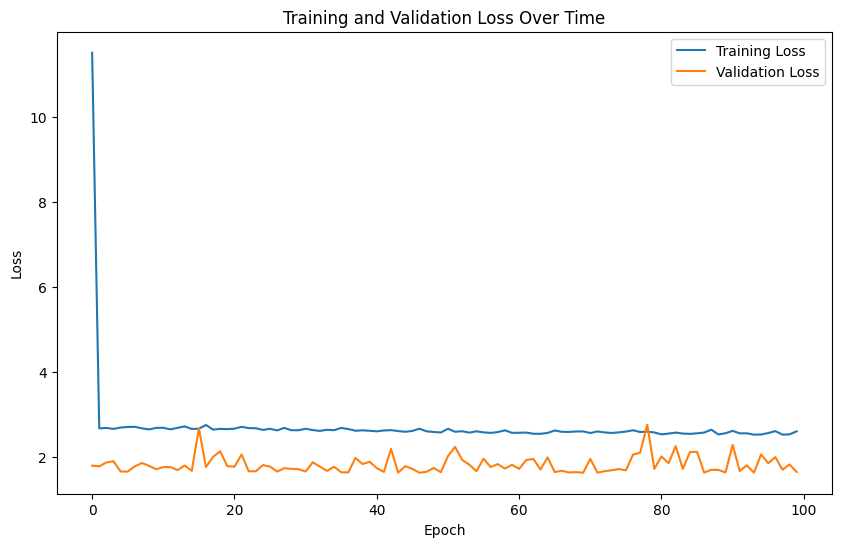

In [36]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [38]:
outfit_index = 0  # Selecting the first outfit as an example

# Extract corresponding embeddings
single_top = Tops_embeddings[outfit_index]
single_bottom = Bottoms_embeddings[outfit_index]
single_bag = Bags_embeddings[outfit_index]
single_shoe = Shoes_embeddings[outfit_index]
single_accessory = Accessories_embeddings[outfit_index]
single_outerwear = Outwear_embeddings[outfit_index]

In [40]:
single_top.shape

(16,)

In [41]:
single_top = np.reshape(single_top, (1, -1))
single_bottom = np.reshape(single_bottom, (1, -1))
single_bag = np.reshape(single_bag, (1, -1))
single_shoe = np.reshape(single_shoe, (1, -1))
single_accessory = np.reshape(single_accessory, (1, -1))
single_outerwear = np.reshape(single_outerwear, (1, -1))

In [45]:
predicted_log_likes = model.predict(
    [single_top, single_bottom, single_shoe, single_bag, single_accessory, single_outerwear]
)


1/1 [==============================] - 0s 23ms/step


In [46]:
predicted_log_likes

array([[5.5719867]], dtype=float32)

In [47]:
predicted_likes = np.exp(predicted_log_likes)
predicted_likes

array([[262.956]], dtype=float32)

In [ ]:
/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/all_images/214181831_1.jpg	

## Prediction model with pretrained models on top 

In [3]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/image_paths_Outfits_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
df_image_paths = pd.DataFrame(data1)

In [4]:
# Define a function to change the paths
def change_path(old_path):
    filename = old_path.split('/')[-1]  # Extract the filename
    new_path = '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/all_images/' + filename
    return new_path
# apply it to the dataframe
for column in df_image_paths.columns[:-1]:
    print(column)
    # Select all columns except the last one
    df_image_paths[column] = df_image_paths[column].apply(change_path)

Tops
Outwear
Bottoms
Shoes
Bags
Accessories


In [5]:
df_image_paths

,Tops,Outwear,Bottoms,Shoes,Bags,Accessories,log_likes
0,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.976351
1,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,3.465736
2,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,6.198479
3,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.356586
4,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,4.934474
...,...,...,...,...,...,...,...
1968,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,7.409742
1969,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.648974
1970,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.950643
1971,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.365976


In [13]:
y = df_image_paths["log_likes"].values
y

array([5.97635091, 3.4657359 , 6.19847872, ..., 5.95064255, 5.36597602,
       3.40119738])

In [6]:
# getting the numpy values of the categories
df_image_paths_numpy = df_image_paths.iloc[:, 0:-1].values

In [7]:
def preprocess_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

In [8]:
# Creates a vectorized version of our function 'preprocess_image_1' in order to apply it on each element of numpy array
vfunc = np.vectorize(preprocess_image_1, otypes=[np.ndarray])
df_images_numpy = vfunc(df_image_paths_numpy)

In [63]:
df_images_numpy.shape

(1973, 6)

In [14]:
Tops_array = df_images_numpy[:,0]
Bottoms_array = df_images_numpy[:,1]
Bags_array = df_images_numpy[:,2]
Outwear_array = df_images_numpy[:,3]
Shoes_array = df_images_numpy[:,4]
Accessories_array = df_images_numpy[:,5]

In [27]:
Tops_array.shape

(1973,)

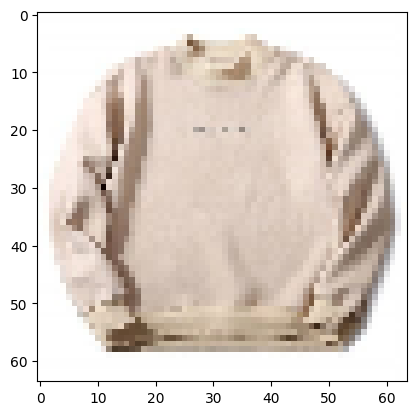

In [15]:
plt.imshow(Tops_array[0])

In [28]:
Tops_array_4D = np.stack(Tops_array, axis=0)
Bottoms_array_4D = np.stack(Bottoms_array, axis=0)
Bags_array_4D = np.stack(Bags_array, axis=0)
Outwear_array_4D = np.stack(Outwear_array, axis=0)
Shoes_array_4D = np.stack(Shoes_array, axis=0)
Accessories_array_4D = np.stack(Accessories_array, axis=0)

In [30]:
Tops_array_4D.shape

(1973, 64, 64, 3)

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [16]:

def create_resnet_model():
    input_shape = (64, 64, 3)  # defining the input shape
    model = ResNet50(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
        )
    
    
    
    # You might also add additional layers here to customize the embeddings
    output = GlobalAveragePooling2D()(model.output)  
    model = Model(inputs=model.input, outputs=output)
    return model

In [ ]:
input_shape = (64, 64, 3)

In [6]:
def create_resnet_model():
    input_shape = (96, 96, 3) 
    # defining the input shape
    model = MobileNetV2(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
        )
    
    
    
    # You might also add additional layers here to customize the embeddings
    output = GlobalAveragePooling2D()(model.output)  
    model = Model(inputs=model.input, outputs=output)
    return model

In [7]:

# Testing to smaller dimension for less demanding computation
Input_s = (96, 96, 3)


# Create pre-trained models
resnet_tops = create_resnet_model()
resnet_bottoms = create_resnet_model()
resnet_shoes = create_resnet_model()
resnet_bags = create_resnet_model()
resnet_accessories = create_resnet_model()
resnet_outerwear = create_resnet_model()

# Image inputs (assuming images are resized to 224x224, per ResNet requirements)
input1 = Input(shape=Input_s, name="Tops")
input2 = Input(shape=Input_s, name="Bottoms")
input3 = Input(shape=Input_s, name="Shoes")
input4 = Input(shape=Input_s, name="Bags")
input5 = Input(shape=Input_s, name="Accessories")
input6 = Input(shape=Input_s, name="Outerwear")

# Getting embeddings from pre-trained models
embedding1 = resnet_tops(input1)
embedding2 = resnet_bottoms(input2)
embedding3 = resnet_shoes(input3)
embedding4 = resnet_bags(input4)
embedding5 = resnet_accessories(input5)
embedding6 = resnet_outerwear(input6)


# Define dense layers per each embedding before concatenation
def dense_layers(embedding):
    x = Dense(64, activation='relu')(embedding)
    x = Dense(16, activation='relu')(x)
    return x

# Applying the dense layers to each embedding
fc1 = dense_layers(embedding1)
fc2 = dense_layers(embedding2)
fc3 = dense_layers(embedding3)
fc4 = dense_layers(embedding4)
fc5 = dense_layers(embedding5)
fc6 = dense_layers(embedding6)

# Concatenate all the fully connected layers' outputs
concatenated = Concatenate()([fc1, fc2, fc3, fc4, fc5, fc6])

# Additional Fully Connected layer on concatenated outputs
fc_final1 = Dense(128, activation='relu')(concatenated)
fc_final2 = Dense(64, activation='relu')(fc_final1)
fc_final3 = Dense(32, activation='relu')(fc_final2)
fc_final4 = Dense(4, activation='relu')(fc_final3)
output = Dense(1,activation='linear')(fc_final4)

# Final Model
model = Model(inputs=[input1, input2, input3, input4, input5, input6], outputs=output)

# Compile the model with regression loss
model.compile(optimizer=Adam(), loss='mse') # Mean Squared Error for regression tasks


9406464/9406464 [==============================] - 2s 0us/step


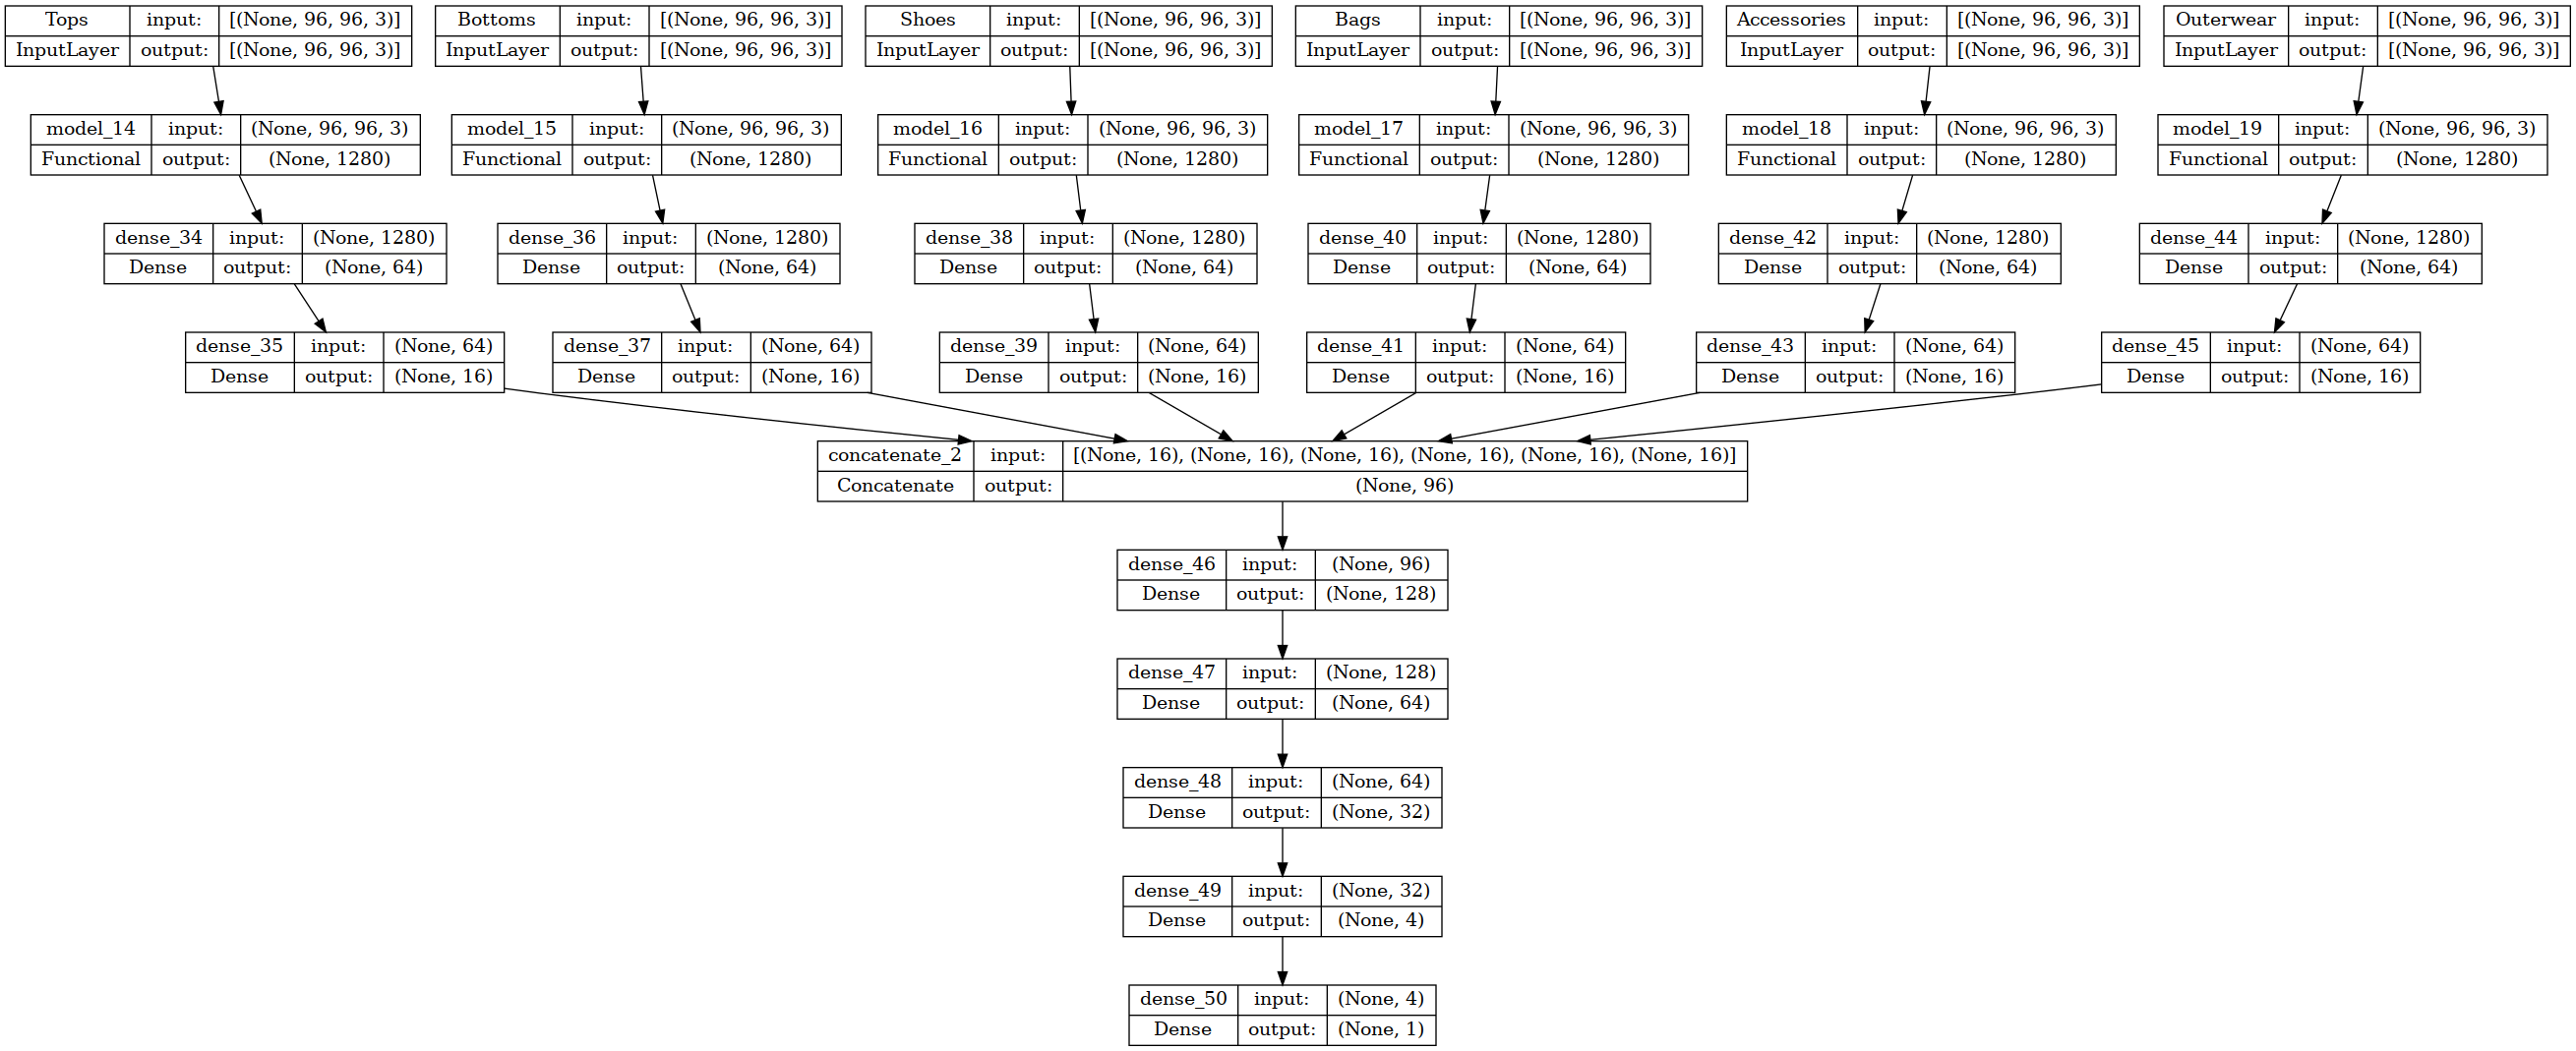

In [8]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [31]:
history = model.fit(
    [Tops_array_4D,
     Bottoms_array_4D,
     Shoes_array_4D, 
     Bags_array_4D,
     Accessories_array_4D,
     Outwear_array_4D],
    y,
    epochs=100,
    batch_size=2,
    validation_split=0.1 # or use `validation_data=(X_val, y_val)` if you have separate validation data
)

Epoch 1/100


NotFoundError: Graph execution error:

Detected at node 'model_26/model_21/conv1_conv/Conv2D' defined at (most recent call last):
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/thanos/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/ioloop.py", line 685, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/ioloop.py", line 738, in _run_callback
      ret = callback()
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/gen.py", line 825, in inner
      self.ctx_run(self.run)
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/gen.py", line 786, in run
      yielded = self.gen.send(value)
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 539, in execute_request
      self.do_execute(
    File "/home/thanos/.local/lib/python3.10/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/thanos/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/thanos/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/thanos/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/thanos/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/thanos/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/thanos/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/thanos/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-31-c08282d26af0>", line 1, in <module>
      history = model.fit(
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/thanos/anaconda3/envs/test/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model_26/model_21/conv1_conv/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16784512 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16784512 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36044800 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36044800 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36274176 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 36274176 bytes.
	 [[{{node model_26/model_21/conv1_conv/Conv2D}}]] [Op:__inference_train_function_169008]

In [ ]:
Tops_array_4D 
Bottoms_array_4D 
Bags_array_4D
Outwear_array_4D
Shoes_array_4D
Accessories_array_4D 